# Intro

Notre répertoire de base est '/project/bootcamp'. Deux sous répertoires contiennent des données 'repo_RTM-007' et 'repo_RTM-0011'
Dans chacun de ces répertoires on trouve

In [2]:
!ls /project/bootcamp/repo_RTM-007

CALIB  eotest_output  _mapper  raw  registry.sqlite3  rerun


L'ensemble logiciel en charge de réduire les images (le 'DM stack') reconnait un certain schéma dans ce répertoire : les répertoires raw rerun et CALIB et les fichier \_mapper et registry.sqlite3. Sous CALIB on trouve des fichiers de calibrations (bias, dark et flats) qui ont été obtenus par le stack, et le répertoire où ce processing est archivé est rerun/calibs:

In [3]:
! ls /project/bootcamp/repo_RTM-007/rerun/calibs

bias  config  dark  postISRCCD	repositoryCfg.yaml  SFLAT_500


Les fichiers d'entrée, dont ceux utilisés pour contruire les fichiers de calibration, sont sous raw. L'outil pour accéder à ces données est le butler du stack: 

In [2]:
from lsst.daf.persistence import Butler
import os
BOOTCAMP_REPO_DIR= '/project/bootcamp/repo_RTM-007/'
butler = Butler(BOOTCAMP_REPO_DIR)
butler.getKeys('raw')

{'run': str, 'visit': int, 'detectorName': str, 'detector': int}

Ces clés sont loin d'être les seules et le butler de présente génération n'est pas très bon à l'introspection. Il faut questionner la database 
directement pour en savoir plus :

In [7]:
! sqlite3 /project/bootcamp/repo_RTM-007/registry.sqlite3 "PRAGMA table_info(raw);"
print('---')
! sqlite3 /project/bootcamp/repo_RTM-007/registry.sqlite3 "select distinct imageType from raw;"
print('---')
! sqlite3 /project/bootcamp/repo_RTM-007/registry.sqlite3 "select distinct testType from raw;"

0|id|integer|0||1
1|run|text|0||0
2|visit|int|0||0
3|filter|text|0||0
4|date|text|0||0
5|dateObs|text|0||0
6|expTime|double|0||0
7|detectorName|text|0||0
8|detector|int|0||0
9|object|text|0||0
10|imageType|text|0||0
11|testType|text|0||0
12|lsstSerial|text|0||0
13|wavelength|int|0||0
14|dayObs|text|0||0
15|testSeqNum|int|0||0
---
BIAS
DARK
FE55
FLAT
fluxcalib
PPUMP
---
DARK
FE55
FLAT
TRAP
LAMBDA
SFLAT_500
SFLAT
PREFLIGHT
READY


A présent on peut faire une requête pour connaître les visites correspondant à un certain type d'image et de test :

In [8]:
print(butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'FE55', 'testType': 'FE55'}))


[258334666, 258334978, 258335291, 258335602, 258335913]


et on peut obtenir l'objet correspondant pour analyse:

In [6]:
dId = {'visit': 258334666, 'detector': 2}
raw = butler.get('raw', **dId)
bias = butler.get('bias', **dId)

In [10]:
print(butler.queryMetadata('raw', ['detector','detectorName'], dataId={'imageType': 'FE55', 'testType': 'FE55'}))


[(0, 'S00'), (1, 'S01'), (2, 'S02'), (3, 'S10'), (4, 'S11'), (5, 'S12'), (6, 'S20'), (7, 'S21'), (8, 'S22')]


Run the isr task from the stack

In [11]:
from lsst.ip.isr import IsrTask
import lsst.afw.detection as afwDetection

isr_config = IsrTask.ConfigClass()

isr_config.doDark=False
isr_config.doFlat=False
isr_config.doFringe=False
isr_config.doDefect=False
isr_config.doAddDistortionModel=False
isr_config.doLinearize=False

isr = IsrTask(config=isr_config)
result = isr.run(raw, bias=bias)

## Fitting two gaussians to the excess of counts on the CCDs

In [12]:
import numpy as np
from scipy.optimize import leastsq

def double_gaussian(x, params):
    (c1, mu1, sigma1, c2, mu2, sigma2) = params
    res =  c1 * np.exp(-(x - mu1)**2.0/(2.0 * sigma1**2.0)) \
          + c2 * np.exp(-(x - mu2)**2.0/(2.0 * sigma2**2.0))
    return res

def double_gaussian_fit(params, x, y):
    fit = double_gaussian( x, params )
    return (fit - y)

In [13]:
xs = []
ys = []
fits = []
detector = result.exposure.getDetector()
for amp in detector:
    #print (amp)
    masked_img = result.exposure.getMaskedImage()
    print (amp.getBBox())
    work_img = masked_img[amp.getBBox()]
    arr = work_img.getImage().getArray()
    
    bkgd = np.median(arr) # estimate a background and subtract it
    print ("median {}".format(bkgd))
    arr -= bkgd

    thresh = afwDetection.Threshold(100)
    fs = afwDetection.FootprintSet(work_img, thresh) # detect hits
    fs = afwDetection.FootprintSet(fs, 1, False) # grow the detection footprints
    fs.makeHeavy(work_img) # what does this do

    foots = fs.getFootprints()

    counts = []
    for foot in foots:
        if foot.getImageArray().size < 25:  # throw out big footprints/CRs since we know the hits should be in a single pixel modulo the charge diffusion.
            counts.append(np.sum(foot.getImageArray()))

    hist = np.histogram(counts, bins=2100.+np.array(range(80))*10.) # generate distribution to fit

    y = hist[0]
    x = [(hist[1][i]+hist[1][i+1])/2 for i in range(len(hist[1])-1)]

    fit = leastsq(double_gaussian_fit, [50.,2270.,50.,10.,2550.,40.], args=(x, y)); # starting parameters were determined by examining a representative distribution
    xs.append(x)
    ys.append(y)
    fits.append(fit)

(minimum=(0, 0), maximum=(511, 2001))
median 9.4033203125
(minimum=(512, 0), maximum=(1023, 2001))
median 9.923443794250488
(minimum=(1024, 0), maximum=(1535, 2001))
median 10.133049011230469
(minimum=(1536, 0), maximum=(2047, 2001))
median 10.251436233520508
(minimum=(2048, 0), maximum=(2559, 2001))
median 10.574106216430664
(minimum=(2560, 0), maximum=(3071, 2001))
median 11.237144470214844
(minimum=(3072, 0), maximum=(3583, 2001))
median 11.479619979858398
(minimum=(3584, 0), maximum=(4095, 2001))
median 11.961129188537598
(minimum=(3584, 2002), maximum=(4095, 4003))
median 12.426342010498047
(minimum=(3072, 2002), maximum=(3583, 4003))
median 12.119621276855469
(minimum=(2560, 2002), maximum=(3071, 4003))
median 11.767223358154297
(minimum=(2048, 2002), maximum=(2559, 4003))
median 11.254194259643555
(minimum=(1536, 2002), maximum=(2047, 4003))
median 11.283731460571289
(minimum=(1024, 2002), maximum=(1535, 4003))
median 11.06981086730957
(minimum=(512, 2002), maximum=(1023, 4003))

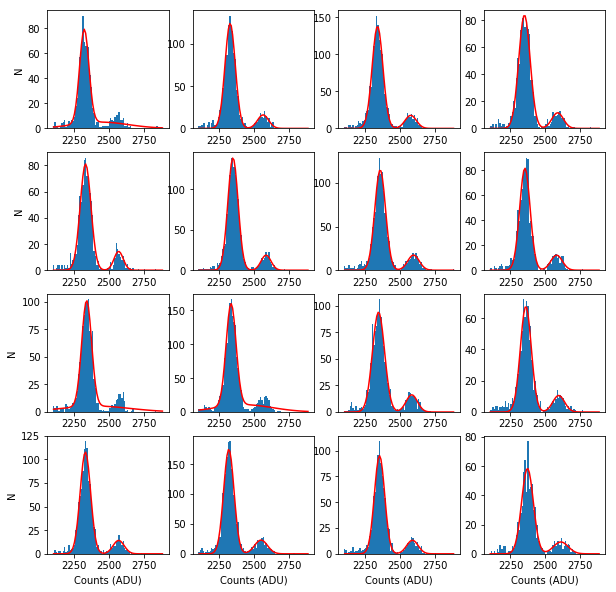

In [14]:
from matplotlib import pylab as plt
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i in range(16):
    x = xs[i]
    y = ys[i]
    fit = fits[i]
    indx = i%4
    indy = i//4
    axs[indx][indy].bar(x, y, width=10)
    axs[indx][indy].plot(x, double_gaussian(x, fit[0]), c='r')
    if indx == 3:
        axs[indx][indy].set_xlabel('Counts (ADU)')
    if indy == 0:
        axs[indx][indy].set_ylabel('N')

In [15]:
FE55_electrons = 1594
for i in range(16):
    print("Gain for amp %s -- %.5f"%(detector[i].getName(), FE55_electrons/fits[i][0][1]))

Gain for amp C10 -- 0.68561
Gain for amp C11 -- 0.68284
Gain for amp C12 -- 0.68053
Gain for amp C13 -- 0.68318
Gain for amp C14 -- 0.68491
Gain for amp C15 -- 0.67897
Gain for amp C16 -- 0.68294
Gain for amp C17 -- 0.68767
Gain for amp C07 -- 0.68107
Gain for amp C06 -- 0.67561
Gain for amp C05 -- 0.67900
Gain for amp C04 -- 0.67693
Gain for amp C03 -- 0.67826
Gain for amp C02 -- 0.67734
Gain for amp C01 -- 0.67541
Gain for amp C00 -- 0.67207


# Get EOTest Results

Accessing and plotting eotest results.

Installation: 

git clone https://github.com/lsst-camera-dh/datacat-utilities.git 
cd datacat-utilities 
git checkout python3 

git clone https://github.com/lsst-camera-dh/eTraveler-clientAPI.git


edit $HOME/notebooks/.user_setups with:

export PYTHONPATH=$PYTHONPATH:/path/to/eTraveler-clientAPI/python:/path/to/datacat-utilites


pip install "git+https://github.com/slaclab/datacat.git#egg=datacat&subdirectory=client/python"


Restart your kernel. 

In [16]:
from get_EO_analysis_results import get_EO_analysis_results
from get_EO_analysis_files import get_EO_analysis_files
from exploreFocalPlane import exploreFocalPlane
from exploreRaft import exploreRaft
from eTraveler.clientAPI.connection import Connection

In [15]:
# Get EO analysis results access results from the eTraveler database
g = get_EO_analysis_results(db='Dev')
raft_list, data = g.get_tests(site_type="I&T-Raft", test_type="gain", run ='5795D')  # get the data for I&T-Raft
res = g.get_results(test_type='gain', data=data, device=raft_list[0])  # get the data for a raft

In [16]:
res.keys()

odict_keys(['E2V-CCD250-260-Dev', 'E2V-CCD250-182', 'E2V-CCD250-175-Dev', 'E2V-CCD250-167-Dev', 'E2V-CCD250-195-Dev', 'E2V-CCD250-201-Dev', 'E2V-CCD250-222-Dev', 'E2V-CCD250-213-Dev', 'E2V-CCD250-177-Dev'])

In [18]:

for d in data['steps']['fe55_raft_analysis']['fe55_raft_analysis']:
    if 'slot' in d.keys():
        if d['slot']=='S02':
            sensor_id=d['sensor_id']
print(sensor_id)
res[sensor_id]

E2V-CCD250-175-Dev


[0.6974157094955444,
 0.6911618709564209,
 0.6917732954025269,
 0.6936643719673157,
 0.6939224600791931,
 0.6897578239440918,
 0.6909717321395874,
 0.6999083161354065,
 0.69338458776474,
 0.6889664530754089,
 0.6889004111289978,
 0.6873788833618164,
 0.6932752132415771,
 0.686771035194397,
 0.6840912699699402,
 0.6851362586021423]

In [21]:
[(FE55_electrons/fits[i][0][1]-res[sensor_id][i])/res[sensor_id][i] for i in range(16)]

[-0.016925379271588773,
 -0.012044694538540202,
 -0.01624883550446875,
 -0.015107835884105159,
 -0.012980524572652483,
 -0.015646409786952253,
 -0.011619256123234762,
 -0.017479091140558095,
 -0.01775398776064118,
 -0.019382526088146945,
 -0.014373315958074567,
 -0.015207725063198107,
 -0.02166015214023107,
 -0.01373564081742282,
 -0.012696921502805752,
 -0.019074142220615466]

# bits and tricks

## Visualiser une image avec firefly

D'abord il faut démarrer le serveur :

In [8]:
# Firefly client imports
from firefly_client import FireflyClient
from IPython.display import IFrame
# stack interface via afwDisaply : afw=Analysis FrameWork
import lsst.afw.display as afwDisplay

my_channel = '{}_test_channel'.format(os.environ['USER'])
server = 'https://lsst-lspdev.ncsa.illinois.edu'
ff='{}/firefly/slate.html?__wsch={}'.format(server, my_channel)
IFrame(ff,800,600);

Ensuite il faut crééer l'objet display pour charger l'exposition souhaitée

In [4]:
afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.getDisplay(frame=1, 
                                    name=my_channel)
afw_display.mtv(raw)

NameError: name 'raw' is not defined

On peut comparer avec ce que retourne la tâche en charge d'éliminer les effets instrumentaux (ISR=Instrument Signature Removal)

In [10]:
from lsst.ip.isr import IsrTask

isr_config = IsrTask.ConfigClass()
isr_config.doDark=False
isr_config.doFlat=False
isr_config.doFringe=False
isr_config.doDefect=False
isr_config.doAddDistortionModel=False
isr_config.doLinearize=False

isr = IsrTask(config=isr_config)
result = isr.run(raw, bias=bias)

In [11]:
afw_display2 = afwDisplay.getDisplay(frame=2, 
                                    name=my_channel)
afw_display2.mtv(result.exposure)

## Une technique rapide pour visualiser une image en utilisant matplotlib

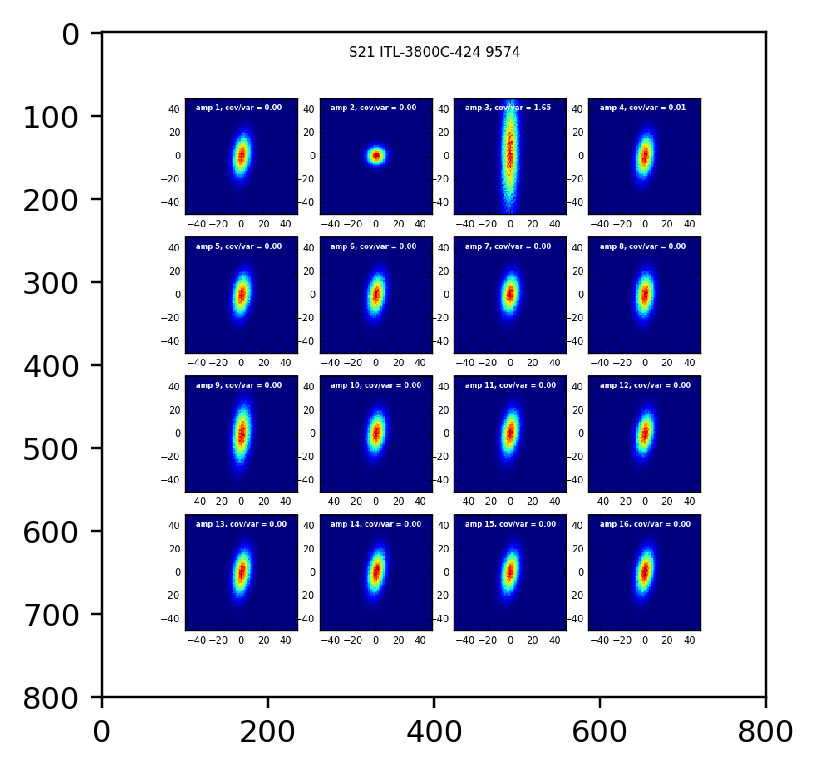

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
matplotlib.rcParams['figure.dpi'] = 220

img = mpimg.imread('/project/rgruendl/SLACmirror/SLACgpfs/jh_archive/LCA-11021_RTM/LCA-11021_RTM-004/9574/rtm_aliveness_exposure/v0/70791/ITL-3800C-424_9574_correlated_noise.png')
plt.imshow(img)
plt.show()

In [14]:
os.environ['PATH']+=':/home/johannct/repos/'

In [17]:
import lsst.afw.display.ds9 as ds9

ds9.mtv(bias)